# Editering og Imputering Kurs løsninger

- [Setup](#setup)
- [Del 1](#del1)
- [Del 2](#del2)
- [Del 3](#del3)


<a id = 'setup'></a>
## Setup
Datasett er basert på Tabell 8.3 fra L.Lohr "Sampling Design and Analysis" bok

In [8]:
offer <- data.frame(person = seq(1:20), #person number
                     alder = c(47, 45, 19, 21, -24, 41, 36, 50, 53, 17, 53, 21, 18, 34, 44, 45, 54, -55, 29, 32), #alder av personen
                     kjoenn = c("M", "F", "M", "F", "M", "kvinne", "M", "M", "F", "M", "F", "F", "KVinne", "M", "M", "M", "F", "F", "F", "F"), #M - menn, F - kvinne
                     aar_utdanning = c(16, NA, 20, NA, 12, NA, 20, 12, 13, 10, 12, 12, 11, 16, 14, 11, 14, 10, 12, 10), #antall aar for gjennomgått utdanning
                     kriminalitetsoffer = c(0, NA, 0, 1, 0, 0, 1, 0, 0, NA, 0, 0, 1, 1, 0, 0, 0, 0, NA, 0), #viser om man har v?rt en kriminalitets offer #1 - ja, 0 - nei
                     voldskriminalitetsoffer = c(0, 1, 0, 1, 1, 0, NA, 0, NA, NA, 0, 0, NA, 0, 0, 0, 0, 0, 0, 0))

For å ta i bruk extra R pakker i Jupyter bruker vi pakkehåndterings verktøy `renv`. Vi har laget lock-filen for kurset og alt kan installere ved følgende kode. Dette vil installere og lagre pakkene i en mappe som heter renv.

In [37]:
library(renv)
renv::restore()

* The library is already synchronized with the lockfile.


<a id = 'del1'></a>
## Del 1


### Oppgave 1.1
- a. Sjekk hvor mange tome (NA) verdier finnes i datasett offer og for hvilke variabler. 
- b. Se om det finnes negative verdier (<0) der de ikke skulle v?re.   
- c. Se om >unifisering< av kategorikal variabel trenges
- d. Finnes det uteligger eller verdier som ikke henger sammen i aar_utdanning?

     person          alder          kjoenn          aar_utdanning  
 Min.   : 1.00   Min.   :-55.0   Length:20          Min.   :10.00  
 1st Qu.: 5.75   1st Qu.: 20.5   Class :character   1st Qu.:11.00  
 Median :10.50   Median : 35.0   Mode  :character   Median :12.00  
 Mean   :10.50   Mean   : 29.0                      Mean   :13.24  
 3rd Qu.:15.25   3rd Qu.: 45.5                      3rd Qu.:14.00  
 Max.   :20.00   Max.   : 54.0                      Max.   :20.00  
                                                    NA's   :3      
 kriminalitetsoffer voldskriminalitetsoffer
 Min.   :0.0000     Min.   :0.0000         
 1st Qu.:0.0000     1st Qu.:0.0000         
 Median :0.0000     Median :0.0000         
 Mean   :0.2353     Mean   :0.1875         
 3rd Qu.:0.0000     3rd Qu.:0.0000         
 Max.   :1.0000     Max.   :1.0000         
 NA's   :3          NA's   :4              

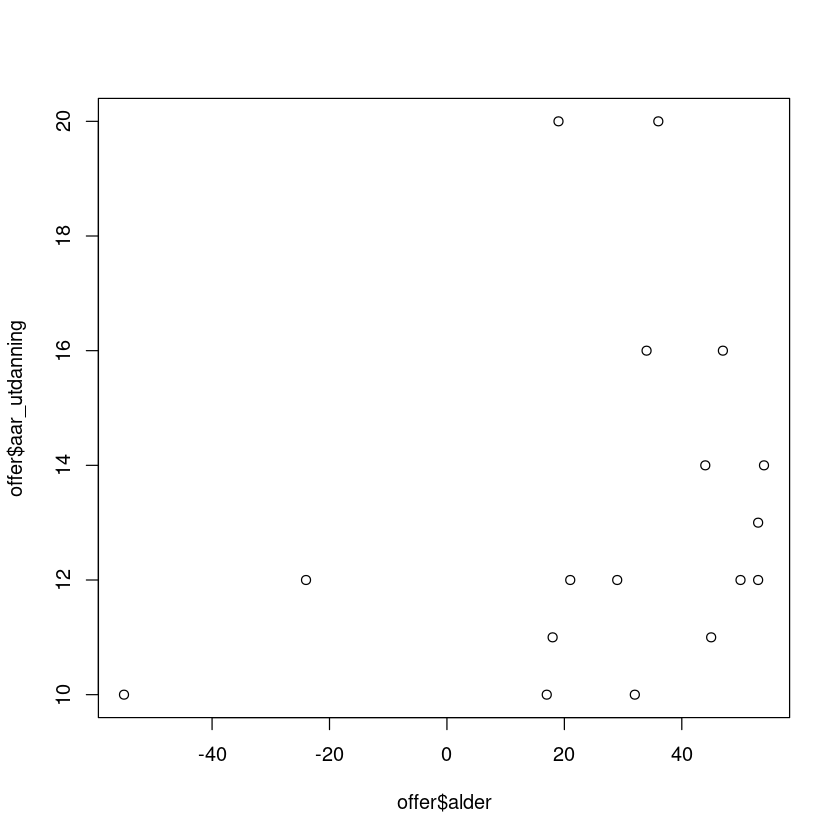

In [9]:
summary(offer)
plot(offer$alder, offer$aar_utdanning)

### Oppgave 1.2
- med bruk av `dcmodify` pakke spesifiser logger og rett feil som du funnet i Task1.b og c. Sjekk med summary om data er korrekt n?. 
- Der aar_utdanning var større enn alder (fra Task.d) sett NA verdi
- Lag resultater i samme datasett


     person          alder          kjoenn          aar_utdanning  
 Min.   : 1.00   Min.   :17.00   Length:20          Min.   :10.00  
 1st Qu.: 5.75   1st Qu.:23.25   Class :character   1st Qu.:11.00  
 Median :10.50   Median :38.50   Mode  :character   Median :12.00  
 Mean   :10.50   Mean   :36.90                      Mean   :12.81  
 3rd Qu.:15.25   3rd Qu.:47.75                      3rd Qu.:14.00  
 Max.   :20.00   Max.   :55.00                      Max.   :20.00  
                                                    NA's   :4      
 kriminalitetsoffer voldskriminalitetsoffer
 Min.   :0.0000     Min.   :0.0000         
 1st Qu.:0.0000     1st Qu.:0.0000         
 Median :0.0000     Median :0.0000         
 Mean   :0.2353     Mean   :0.1875         
 3rd Qu.:0.0000     3rd Qu.:0.0000         
 Max.   :1.0000     Max.   :1.0000         
 NA's   :3          NA's   :4              

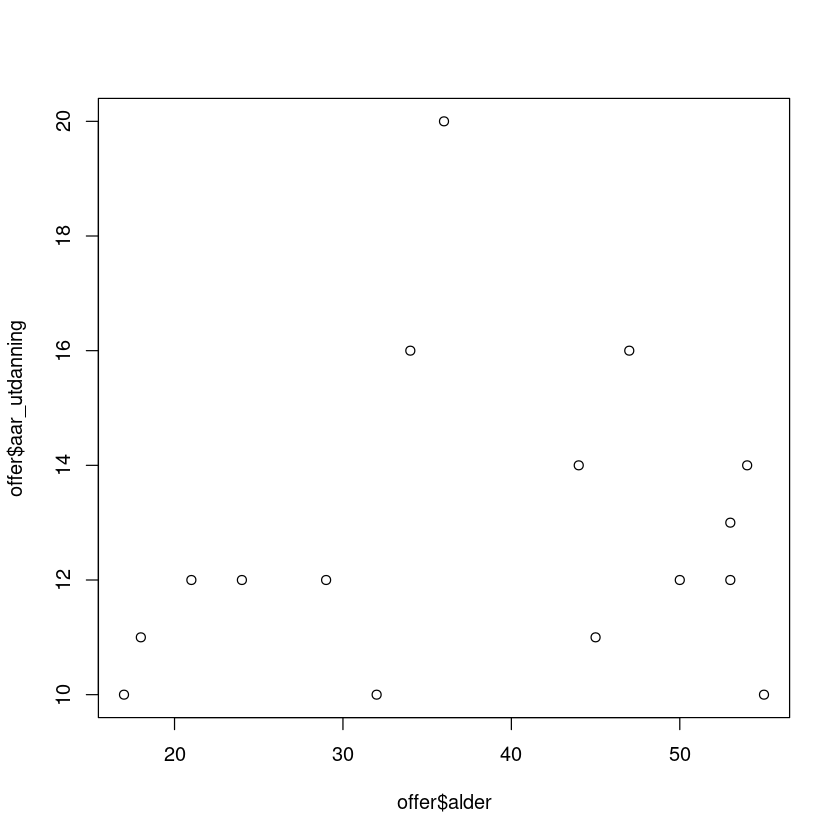

In [10]:
library(dcmodify)
m1_2  <- modifier( if (alder  <  0)  alder <- abs(alder),   
                if (toupper(kjoenn) == "KVINNE") kjoenn <- "F",
                if (alder <= aar_utdanning) aar_utdanning <- NA)
offer  <-  modify(offer, m1_2)
summary(offer)
plot(offer$alder, offer$aar_utdanning)

### Oppgave 1.3
- Hvis voldskriminalitetsoffer likt 1, da må kriminalitetsoffer være 1, og hvis kriminalitetsoffer likt 0 da voldskriminalitetsoffer må være 0 og. 
- korrekt feil & fyll inn manglende verdier med bruk av disse deduktive regler
- Lag resultater i samme datasett

In [12]:
library(magrittr)

head(offer)
m1_3 <- modifier(if (voldskriminalitetsoffer == 1 & (is.na(kriminalitetsoffer)| kriminalitetsoffer == 0) )  kriminalitetsoffer <- 1,   
            if (kriminalitetsoffer == 0 & (is.na(voldskriminalitetsoffer)| voldskriminalitetsoffer == 1) ) voldskriminalitetsoffer <- 0 )
offer  <-  modify(offer, m1_3)
 
offer %<>% modify_so(if (voldskriminalitetsoffer == 1 & (is.na(kriminalitetsoffer)| kriminalitetsoffer == 0) )  kriminalitetsoffer <- 1,   
                if (kriminalitetsoffer == 0 & (is.na(voldskriminalitetsoffer)| voldskriminalitetsoffer == 1) ) voldskriminalitetsoffer <- 0 )


Attaching package: ‘magrittr’


The following object is masked from ‘package:SparkR’:

    not




,person,alder,kjoenn,aar_utdanning,kriminalitetsoffer,voldskriminalitetsoffer
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,1,47,M,16,0,0
2,2,45,F,NA,1,1
3,3,19,M,NA,0,0
4,4,21,F,NA,1,1
5,5,24,M,12,1,1
6,6,41,F,NA,0,0


### Oppgave 1.4
- Imputer aar_utdaning der mangler verdier. Bruk gjennomsnitt-imputering. Her kan brukes både dcmodify og simputation pakker
- Lag resultater til en ny datasett: offer_1_4 med dcmodify

In [18]:
# Med dcmodify
offer %>% modify_so(if (is.na(aar_utdanning))  aar_utdanning <- round(mean(offer$aar_utdanning, na.rm =TRUE)) ) -> offer_1_4
head(offer_1_4)

In [19]:
# Med simputation
library(simputation)
offer %>% impute_proxy(aar_utdanning ~ mean(aar_utdanning, na.rm =TRUE)) -> offer_1_4
head(offer_1_4)

<a id = 'del2'></a>
## Del 2
### Oppgave 2.1
- Del personer i celler og bruk stratifisert gjennomsnitt-imputering for aar_utdanning. Bruk pakke simputation
- Grupper spesifiseres etter kjønn og alder <=34 & > 34
- Lag resultater til en ny datasett: offer_2_1

In [22]:
library(simputation)

offer$celle <- paste0(offer$kjoenn, sign(offer$alder > 34))
offer %>% impute_proxy(aar_utdanning ~ mean(aar_utdanning, na.rm =TRUE)|celle) -> offer_2_1
offer_2_1

person,alder,kjoenn,aar_utdanning,kriminalitetsoffer,voldskriminalitetsoffer,celle
<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,47,M,16.00000,0,0,M1
2,45,F,12.25000,1,1,F1
3,19,M,12.66667,0,0,M0
4,21,F,11.25000,1,1,F0
5,24,M,12.00000,1,1,M0
6,41,F,12.25000,0,0,F1
7,36,M,20.00000,1,NA,M1
8,50,M,12.00000,0,0,M1
9,53,F,13.00000,0,0,F1


### Oppgave 2.2
- Bruk samme datasett som i øvelser 1, Task 4. Bruk nærmest nabo hotdeck imputering for variabel kriminalitetsoffer og voldskriminalitetsoffer.
- Bruk alder og kjønn for å beregne avstand

In [23]:
set.seed(1000)
offer %>% impute_knn(aar_utdanning + kriminalitetsoffer + voldskriminalitetsoffer ~ alder + kjoenn, pool = "complete", k = 1) -> offer_2_2
offer_2_2

# NB: for å kontrollere hvem ble bruk som nabo kan oppretes variabel som inneholder person nummer med satt NA verdier der kriminalitetsoffer mangler: 
t <- offer
t$nabo <- t$person
t$nabo[is.na(t$aar_utdanning)|is.na(t$kriminalitetsoffer)|is.na(t$voldskriminalitetsoffer)] <- NA
set.seed(1000)
t %>% impute_knn(aar_utdanning + kriminalitetsoffer + voldskriminalitetsoffer + nabo ~ alder + kjoenn, pool = "complete", k = 1)


,person,alder,kjoenn,aar_utdanning,kriminalitetsoffer,voldskriminalitetsoffer,celle
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,1,47,M,16,0,0,M1
2,2,45,F,11,1,1,F1
3,3,19,M,12,0,0,M0
4,4,21,F,12,1,1,F0
5,5,24,M,12,1,1,M0
6,6,41,F,14,0,0,F1
7,7,36,M,20,1,0,M1
8,8,50,M,12,0,0,M1
9,9,53,F,13,0,0,F1


,person,alder,kjoenn,aar_utdanning,kriminalitetsoffer,voldskriminalitetsoffer,celle,nabo
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,1,47,M,16,0,0,M1,1
2,2,45,F,11,1,1,F1,16
3,3,19,M,12,0,0,M0,12
4,4,21,F,12,1,1,F0,12
5,5,24,M,12,1,1,M0,5
6,6,41,F,14,0,0,F1,15
7,7,36,M,20,1,0,M1,14
8,8,50,M,12,0,0,M1,8
9,9,53,F,13,0,0,F1,9


### Oppgave 2.3
- Bruk samme datasett som i øvelser 1.4. Bruk Linear regresjon imputering for variabel kriminalitetsoffer og voldskriminalitetsoffer.

In [25]:
offer %>% impute_lm(aar_utdanning + kriminalitetsoffer + voldskriminalitetsoffer ~ alder + kjoenn) -> offer_2_3
offer_2_3

,person,alder,kjoenn,aar_utdanning,kriminalitetsoffer,voldskriminalitetsoffer,celle
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,1,47,M,16.00000,0.0000000,0.0000000,M1
2,2,45,F,11.97911,1.0000000,1.0000000,F1
3,3,19,M,13.13677,0.0000000,0.0000000,M0
4,4,21,F,11.00159,1.0000000,1.0000000,F0
5,5,24,M,12.00000,1.0000000,1.0000000,M0
6,6,41,F,11.81619,0.0000000,0.0000000,F1
7,7,36,M,20.00000,1.0000000,0.1601906,M1
8,8,50,M,12.00000,0.0000000,0.0000000,M1
9,9,53,F,13.00000,0.0000000,0.0000000,F1


### Oppgave 2.4
- Samme som i 2.3, men bruk predictive mean matching(pmm)
- Lag resultater til en ny datasett: offer_2_4

In [26]:
set.seed(1000)
offer %>% impute_pmm(aar_utdanning + kriminalitetsoffer + voldskriminalitetsoffer ~ alder + kjoenn, predictor = impute_lm, pool = "complete") -> offer_2_4
offer_2_4

,person,alder,kjoenn,aar_utdanning,kriminalitetsoffer,voldskriminalitetsoffer,celle
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,1,47,M,16,0,0,M1
2,2,45,F,12,1,1,F1
3,3,19,M,13,0,0,M0
4,4,21,F,11,1,1,F0
5,5,24,M,12,1,1,M0
6,6,41,F,12,0,0,F1
7,7,36,M,20,1,0,M1
8,8,50,M,12,0,0,M1
9,9,53,F,13,0,0,F1


### Oppgave 2.5
- plot resultater mot aar_utdanning

,person,alder,kjoenn,aar_utdanning,kriminalitetsoffer,voldskriminalitetsoffer,celle
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
2,2,45,F,NA,1,1,F1
4,4,21,F,NA,1,1,F0
6,6,41,F,NA,0,0,F1
9,9,53,F,13,0,0,F1
11,11,53,F,12,0,0,F1
12,12,21,F,12,0,0,F0
13,13,18,F,11,1,NA,F0
17,17,54,F,14,0,0,F1
18,18,55,F,10,0,0,F1


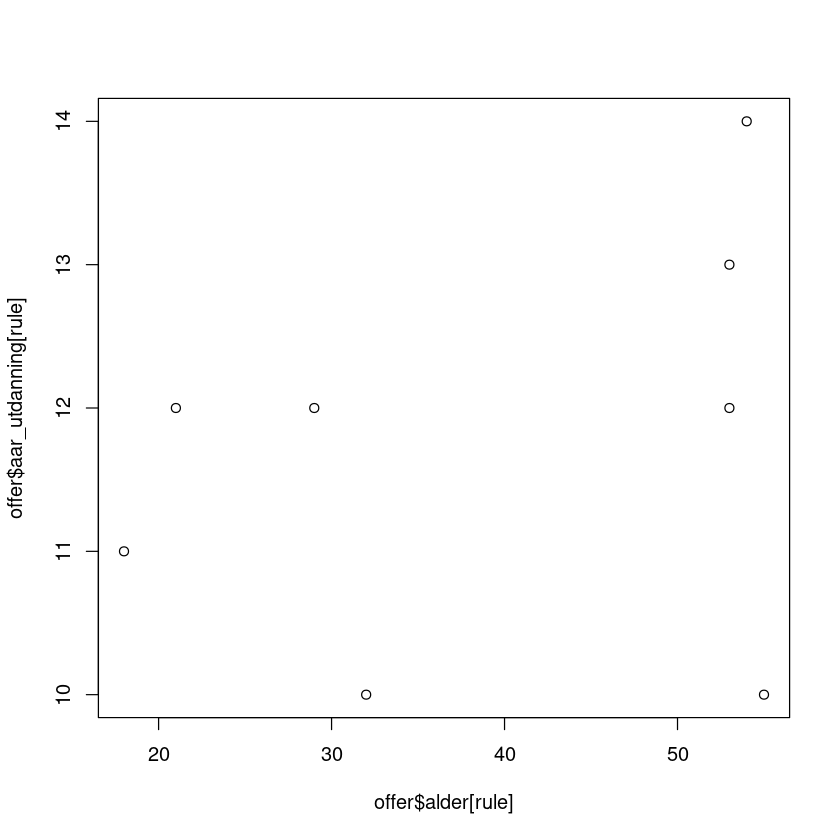

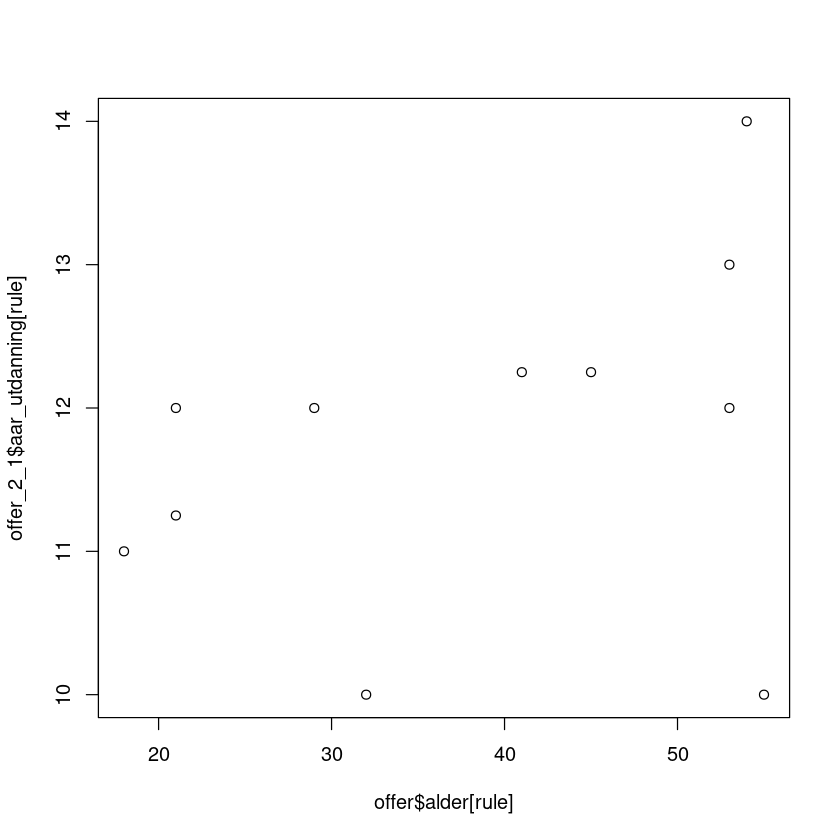

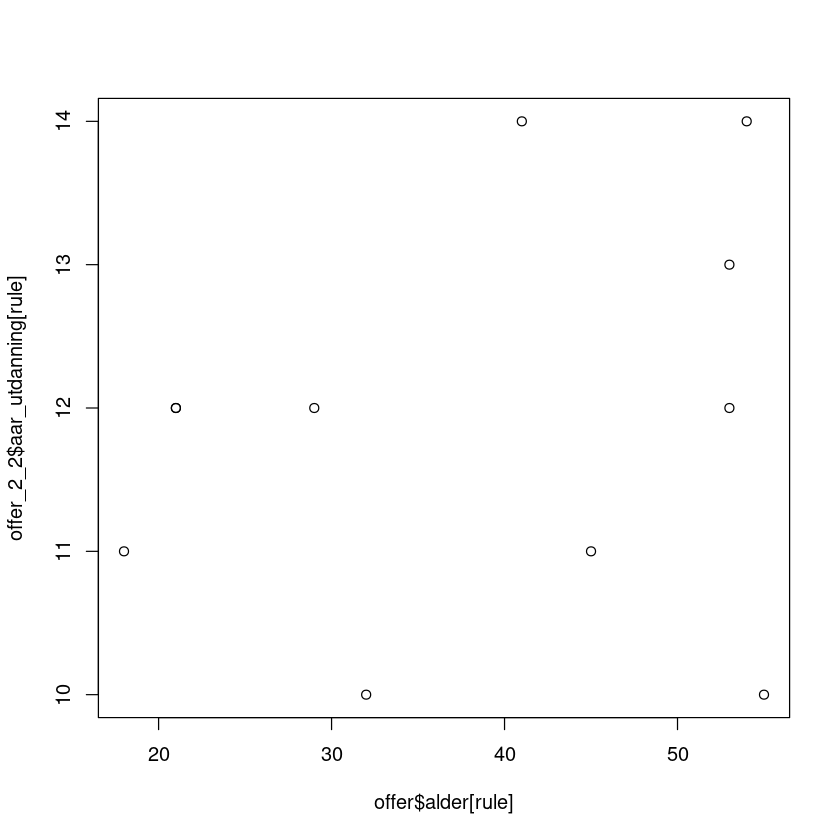

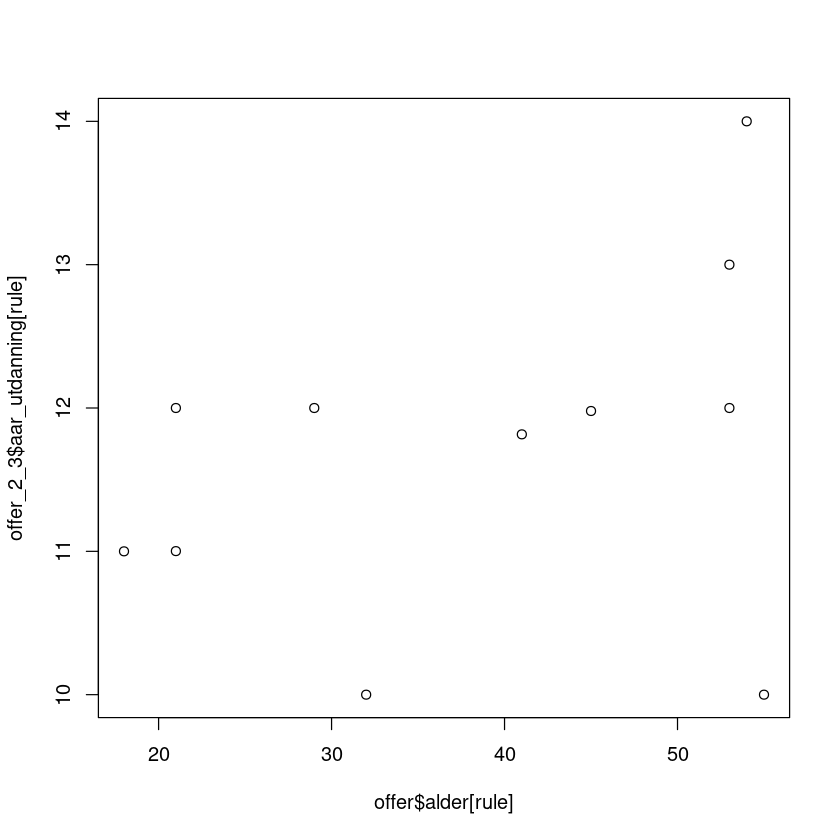

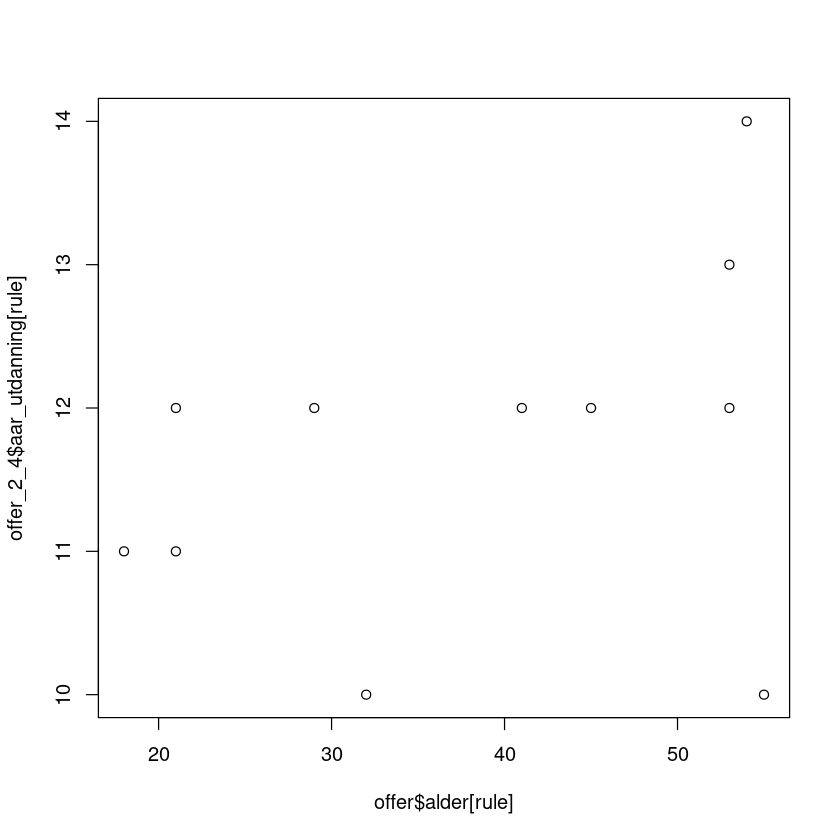

In [28]:
rule <- t$kjoenn == "F"

plot(offer$alder[rule], offer$aar_utdanning[rule])
plot(offer$alder[rule], offer_2_1$aar_utdanning[rule])
plot(offer$alder[rule], offer_2_2$aar_utdanning[rule])
plot(offer$alder[rule], offer_2_3$aar_utdanning[rule])
plot(offer$alder[rule], offer_2_4$aar_utdanning[rule])

<a id = 'del3'></a>
## Del 3

### Oppgave
Bruk rå `offerdata` og spor endringer i oppgave 1.2, 1.3 og med bruk av lumberjack pakke svar på spørsmålene. Dermed kjør inn data fra [Setup](#setup) på nytt først.

In [30]:
library(lumberjack)

offer %>>%
  start_log(cellwise$new(key = "person")) %>>%
  start_log(expression_logger$new(total_utd = sum(aar_utdanning, na.rm = TRUE), count_tom = sum(is.na(aar_utdanning)))) %>>%
  modify(m1_2) %>>%
  modify(m1_3) %>>%
  impute_pmm(aar_utdanning + kriminalitetsoffer + voldskriminalitetsoffer ~ alder + kjoenn, predictor = impute_lm) %>>%
  dump_log("cellwise", file = "offer_3_1_cellwise.csv") %>>%
  dump_log("expression_logger", file = "offer_3_1_expr.csv")
  
offer_3_1_celllwise <- read.csv("offer_3_1_cellwise.csv")
offer_3_1_expr <- read.csv("offer_3_1_expr.csv")

Dumped a log at offer_3_1_cellwise.csv

Dumped a log at offer_3_1_expr.csv



,person,alder,kjoenn,aar_utdanning,kriminalitetsoffer,voldskriminalitetsoffer,celle
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,1,47,M,16,0,0,M1
2,2,45,F,12,1,1,F1
3,3,19,M,13,0,0,M0
4,4,21,F,11,1,1,F0
5,5,24,M,12,1,1,M0
6,6,41,F,12,0,0,F1
7,7,36,M,20,1,0,M1
8,8,50,M,12,0,0,M1
9,9,53,F,13,0,0,F1


### Oppgave 3.1
- Finn prosent personer som fikk misnt 1 editering

In [31]:
length(unique(offer_3_1_celllwise$key)) / nrow(offer) * 100

[1] 40

### Oppgave 3.2
- finn navn og antall variabler som ble editert

In [32]:
unique(offer_3_1_celllwise$variable)
length(unique(offer_3_1_celllwise$variable))


[1] "kriminalitetsoffer"      "voldskriminalitetsoffer"
[3] "aar_utdanning"

[1] 3

### Oppgave 3.3
- finn prosent editerte i hver variabel fra b.

In [35]:
library(dplyr)
offer_3_1_celllwise %>% group_by(variable) %>% summarise(n_endringer = n_distinct(key))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:SparkR’:

    arrange, between, coalesce, collect, contains, count, cume_dist,
    dense_rank, desc, distinct, explain, expr, filter, first, group_by,
    intersect, lag, last, lead, mutate, n, n_distinct, ntile,
    percent_rank, rename, row_number, sample_frac, select, slice, sql,
    summarize, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




variable,n_endringer
<chr>,<int>
aar_utdanning,4
kriminalitetsoffer,2
voldskriminalitetsoffer,3


### Oppgave 3.4
- finn steget der endringen i totalen av aar_utdaning ble den største

In [36]:
offer_3_1_expr %<>% mutate(diff = total_utd - lag(total_utd)) %>% modify_so(if(is.na(diff)) diff <- 0)
max_steg <- match(max(offer_3_1_expr$diff), offer_3_1_expr$diff, )
offer_3_1_expr[(max_steg-1):max_steg, ]


,step,srcref,expression,total_utd,count_tom,diff
,<int>,<lgl>,<chr>,<int>,<int>,<dbl>
3,3,NA,modify(m1_3),205,4,0
4,4,NA,"impute_pmm(aar_utdanning + kriminalitetsoffer + voldskriminalitetsoffer ~ alder + kjoenn, predictor = impute_lm)",253,0,48
